# Task 4: Demonstrating Quantum Advantage

In [110]:
"""
This task is intentionally open-ended, so no boilerplate code is provided.

You may use this notebook to develop your solution, or create a separate file if you prefer.
We recommend starting by copying over your previous implementations of the QRNG, TRNG, and PRNG.
Then, explore ways to modularize and combine these components to design a use case that
demonstrates the unique advantages of quantum randomness.

Your write-up can be included directly in this notebook or submitted separately.
You're welcome to prepare it as a Google Doc or LaTeX document and upload a PDF to the GitHub repository—
just be sure to clearly indicate where it can be found if it's not included here.
"""

"\nThis task is intentionally open-ended, so no boilerplate code is provided.\n\nYou may use this notebook to develop your solution, or create a separate file if you prefer.\nWe recommend starting by copying over your previous implementations of the QRNG, TRNG, and PRNG.\nThen, explore ways to modularize and combine these components to design a use case that\ndemonstrates the unique advantages of quantum randomness.\n\nYour write-up can be included directly in this notebook or submitted separately.\nYou're welcome to prepare it as a Google Doc or LaTeX document and upload a PDF to the GitHub repository—\njust be sure to clearly indicate where it can be found if it's not included here.\n"

In [111]:
%pip install requests
%pip install numpy
%pip install matplotlib
%pip install pyaudio
%pip install psutil
%pip install pandas
%pip install seaborn
%pip install scipy
%pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Package Imports - feel free to add what you think might be useful! 
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.stats import kstest, laplace
from ucimlrepo import fetch_ucirepo
import hashlib
import struct
import psutil
import platform
import math
import pandas as pd
import seaborn as sns

In [113]:
def get_qrng_floats(n, min_val=0.0, max_val=1.0):
    url = "https://qrng.idqloud.com/api/1.0/double"
    headers = {"X-API-KEY": "aTo4BKRvnc49uRWDk034zaua87vGRXKk9TMLdfkI"}
    max_chunk = 16
    results = []
    
    # Split requests into chunks
    for _ in range(n // max_chunk):
        response = requests.get(
            url,
            headers=headers,
            params={
                "min": str(min_val),
                "max": str(max_val),
                "quantity": str(max_chunk)
            }
        )
        response.raise_for_status()
        results.extend(response.json()['data'])
    
    # Handle remaining numbers
    remaining = n % max_chunk
    if remaining > 0:
        response = requests.get(
            url,
            headers=headers,
            params={
                "min": str(min_val),
                "max": str(max_val),
                "quantity": str(remaining)
            }
        )
        response.raise_for_status()
        results.extend(response.json()['data'])
    
    return np.array(results, dtype=np.float64)

In [114]:
def get_laplace_transform(P, epsilon):
    # P is the scaled random numbers from get_qrng_floats()
    # Epsilon is the threshold for privacy (smaller epsilon = more privacy = less utility)
    b = 1 / epsilon
    laplace = []
    for p in P:
        if p == 0:
            laplace.append(float('-inf'))
        elif p < 0.5:
            laplace.append(b * math.log(2 * p))
        else:
            laplace.append(-b * math.log(2 * (1 - p)))
    return laplace

In [115]:
random_numbers = get_qrng_floats(40)
print(random_numbers)


[0.71222961 0.16878175 0.651271   0.92282585 0.92997067 0.09824742
 0.36434922 0.06130033 0.93258874 0.6120797  0.37759661 0.98233887
 0.95499332 0.2778633  0.25721986 0.69716571 0.96282194 0.59824994
 0.69812369 0.27241532 0.94059392 0.1893218  0.72919436 0.8927002
 0.66868541 0.25400369 0.53759518 0.05608024 0.47160655 0.92968661
 0.30444058 0.49176519 0.41895162 0.38157988 0.65647917 0.42061024
 0.5546587  0.14754889 0.58204954 0.10679495]


In [116]:
epsilon = 0.25
laplace_transform = get_laplace_transform(random_numbers, epsilon)

In [117]:
size = 20

changes = -np.random.poisson(2, size)
positive = 324 + np.maximum.reduce([changes, np.random.normal(0, 4, size).astype(int)]).cumsum()
total = 100000 + changes.cumsum()

In [118]:
hiv_df = pd.DataFrame(np.array([positive, total]).T, columns=["Positive", "Total"])
hiv_df.index = range(2000, 2020)

In [119]:
hiv_df["Percent"] = hiv_df["Positive"] / hiv_df["Total"]

In [120]:
display(hiv_df)

,Positive,Total,Percent
2000,330,99998,0.003300
2001,330,99996,0.003300
2002,329,99995,0.003290
2003,330,99993,0.003300
2004,331,99991,0.003310
2005,329,99989,0.003290
2006,327,99985,0.003270
2007,328,99983,0.003281
2008,328,99982,0.003281
2009,334,99981,0.003341


In [121]:
hiv_df_differential_privacy = hiv_df.copy(deep=True)
hiv_df_differential_privacy["Positive"] = hiv_df["Positive"] + np.array(laplace_transform[:20]).astype(int)
hiv_df_differential_privacy["Total"] = hiv_df["Total"] + np.array(laplace_transform[20:]).astype(int)
hiv_df_differential_privacy["Percent"] = hiv_df_differential_privacy["Positive"] / hiv_df_differential_privacy["Total"]

display(hiv_df_differential_privacy)

,Positive,Total,Percent
2000,332,100006,0.003320
2001,326,99993,0.003260
2002,330,99997,0.003300
2003,337,99999,0.003370
2004,338,99992,0.003380
2005,323,99987,0.003230
2006,326,99985,0.003260
2007,320,99975,0.003201
2008,336,99982,0.003361
2009,335,99988,0.003350


In [122]:
hiv_df.to_csv("hiv_data.csv", index=True)
hiv_df_differential_privacy.to_csv("hiv_data_dp.csv", index=True)

In [123]:
hiv_df = pd.read_csv("hiv_data.csv", index_col=0)
hiv_df_differential_privacy = pd.read_csv("hiv_data_dp.csv", index_col=0)

In [124]:
# Calculate IQR for the 'Positive' column
q1 = hiv_df['Positive'].quantile(0.25)
q3 = hiv_df['Positive'].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out rows with outliers in the 'Positive' column
filtered_hiv_df = hiv_df[(hiv_df['Positive'] >= lower_bound) & (hiv_df['Positive'] <= upper_bound)]
filtered_hiv_df_differential_privacy = hiv_df_differential_privacy.loc[filtered_hiv_df.index]

# Recalculate correlation after removing outliers
positive_corr = np.corrcoef(filtered_hiv_df['Positive'], filtered_hiv_df_differential_privacy['Positive'])[0, 1]
total_corr = np.corrcoef(hiv_df['Total'], hiv_df_differential_privacy['Total'])[0, 1]

print(f"Correlation between Positive columns (after removing outliers): {positive_corr:.4f}")
print(f"Correlation between Total columns: {total_corr:.4f}")


Correlation between Positive columns (after removing outliers): 0.7599
Correlation between Total columns: 0.9642


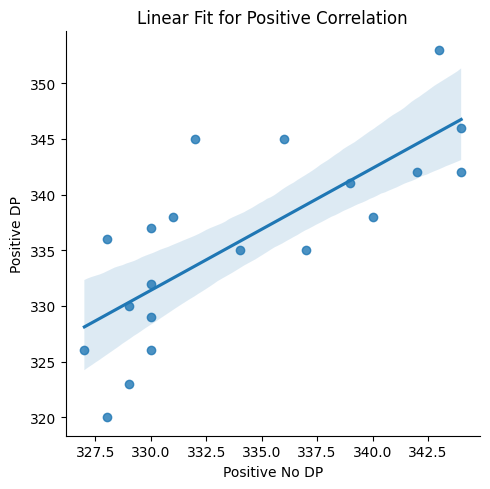

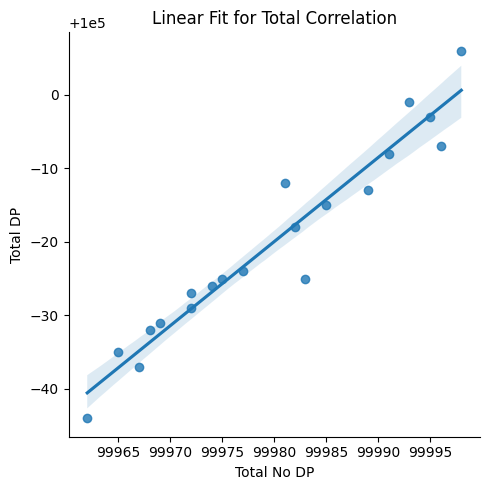

In [125]:
sns.lmplot(x='Positive No DP', y='Positive DP', data=pd.DataFrame({
    'Positive No DP': filtered_hiv_df['Positive'],
    'Positive DP': filtered_hiv_df_differential_privacy['Positive']
}))
plt.title('Linear Fit for Positive Correlation')
plt.tight_layout()
plt.show()

sns.lmplot(x='Total No DP', y='Total DP', data=pd.DataFrame({
    'Total No DP': filtered_hiv_df['Total'],
    'Total DP': filtered_hiv_df_differential_privacy['Total']
}))
plt.title('Linear Fit for Total Correlation')
plt.tight_layout()
plt.show()


(20,)


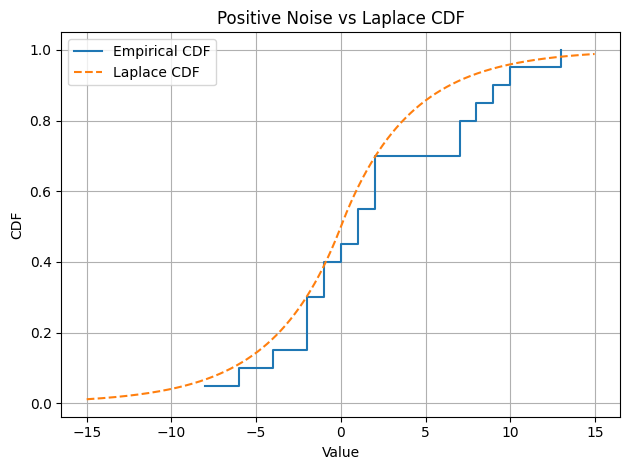

(20,)


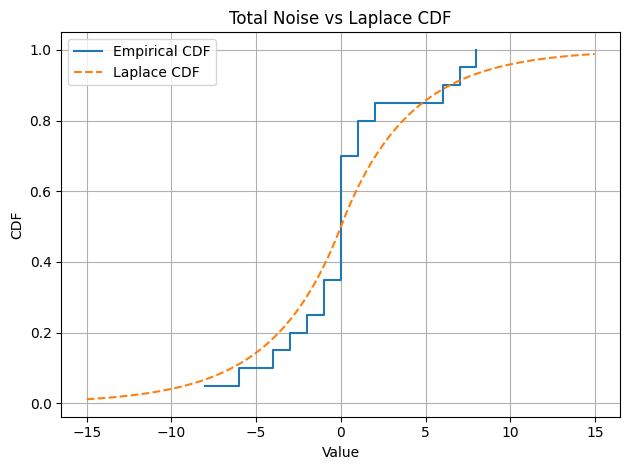

In [126]:
import matplotlib.pyplot as plt

def plot_cdf_vs_laplace(series, title):
    print(series.shape)
    data = series.dropna().values
    data.sort()

    loc = 0
    scale = 1 / epsilon

    # CDF from observed/empircal data
    ecdf = np.arange(1, len(data)+1) / len(data)
    # Theoretical CDF
    garp = (np.arange(1000) / 1000) * 30 - 15
    laplace_cdf = laplace.cdf(garp, loc=loc, scale=scale)

    plt.plot(data, ecdf, drawstyle='steps-post', label='Empirical CDF')
    plt.plot(garp, laplace_cdf, linestyle='--', label='Laplace CDF')
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("CDF")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_cdf_vs_laplace(hiv_df_differential_privacy['Positive'] - hiv_df['Positive'], "Positive Noise vs Laplace CDF")
plot_cdf_vs_laplace(hiv_df_differential_privacy['Total'] - hiv_df['Total'], "Total Noise vs Laplace CDF")


In [127]:
columns = [
    'age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode',
    'education', 'wage_per_hour', 'enroll_in_edu_inst_last_wk', 'marital_status',
    'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin',
    'sex', 'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat',
    'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_status',
    'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat',
    'detailed_household_summary_in_household', 'instance_weight', 'migration_code_change_in_msa',
    'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18',
    'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self',
    'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin',
    'veterans_benefits', 'weeks_worked_in_year', 'year', 'income'
]
# fetch dataset
census_income_kdd = fetch_ucirepo(id=117)

In [128]:
df_features = census_income_kdd.data.features 
df_targets = census_income_kdd.data.targets 

# include everything BUT income
df_features.columns = columns[:-1]
# include ONLY income
df_targets.columns = [columns[-1]]

df = pd.concat([df_features, df_targets], axis=1)

print(df)

        age                  class_of_worker  detailed_industry_recode  \
0        73                  Not in universe                         0   
1        58   Self-employed-not incorporated                         4   
2        18                  Not in universe                         0   
3         9                  Not in universe                         0   
4        10                  Not in universe                         0   
...     ...                              ...                       ...   
199518   87                  Not in universe                         0   
199519   65       Self-employed-incorporated                        37   
199520   47                  Not in universe                         0   
199521   16                  Not in universe                         0   
199522   32                          Private                        42   

        detailed_occupation_recode                    education  \
0                                0         H

In [129]:
# Example: searching dataset by father's country of birth
counts = df['country_of_birth_father'].value_counts()
print("True counts per father's country of birth:")
print(counts)

True counts per father's country of birth:
country_of_birth_father
United-States                   160479
Mexico                            9781
Puerto-Rico                       2473
Italy                             1844
Canada                            1451
Germany                           1382
Philippines                       1231
Poland                            1110
Cuba                              1108
El-Salvador                       1108
Dominican-Republic                1103
England                            903
China                              760
Columbia                           612
South Korea                        609
Ireland                            599
India                              581
Vietnam                            473
Japan                              469
Jamaica                            453
Guatemala                          444
Ecuador                            375
Peru                               355
Haiti                              3

In [159]:
n = len(counts)
random_numbers = get_qrng_floats(n)
epsilon = 0.25
laplace_noise = get_laplace_transform(random_numbers, epsilon)
privatized_counts = [max(0, count + noise) for count, noise in zip(counts.values, laplace_noise)]

In [144]:
df_plot = pd.DataFrame({
    'Category': counts.index,
    'True Count': counts.values,
    # 'Privatized Count': privatized_counts
    'Privatized Count': [int(x) for x in privatized_counts]
})

print(df_plot)

                      Category  True Count  Privatized Count
0                United-States       43832             43834
1                       Mexico         951               951
2                  Philippines         295               294
3                      Germany         206               201
4                  Puerto-Rico         184               183
5                       Canada         182               174
6                  El-Salvador         155               152
7                        India         151               141
8                         Cuba         138               139
9                      England         127               133
10                       China         122               121
11                       South         115               111
12                     Jamaica         106               105
13                       Italy         105               105
14          Dominican-Republic         103               106
15                      

True Counts Mean: 1170.3658536585365
Privatized Counts Mean: 1170.0243902439024
(41,)


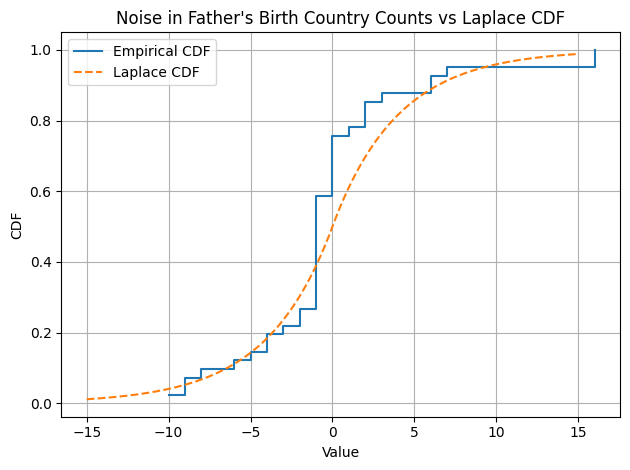

In [145]:
privatized_counts_series = pd.Series([int(x) for x in privatized_counts], index=counts.index)

print("True Counts Mean:", counts.mean())
print("Privatized Counts Mean:", privatized_counts_series.mean())


# Compute differences between privatized and true counts
differences = privatized_counts_series - counts

# Plot CDF of differences to verify noise distribution
plot_cdf_vs_laplace(differences, "Noise in Father's Birth Country Counts vs Laplace CDF")

In [146]:
differences = privatized_counts_series - counts
statistic, p_value = kstest(differences, 'laplace', args=(0, 4))
print(f"KS statistic = {statistic:.4f}, p-value = {p_value:.4f}")

KS statistic = 0.2561, p-value = 0.0074


In [158]:
# Calculate IQR for the 'Positive' column
q1 = df_plot['True Count'].quantile(0.25)
q3 = df_plot['True Count'].quantile(0.75)
iqr = q3 - q1

# Define bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out rows with outliers in the 'Positive' column
filtered_df_plot = df_plot[(df_plot['True Count'] >= lower_bound) & (df_plot['True Count'] <= upper_bound)]

# Recalculate correlation after removing outliers
df_corr = np.corrcoef(filtered_df_plot['True Count'], filtered_df_plot['Privatized Count'])[0, 1]

print(f"Correlation between True and Privatized Counts (after removing outliers): {df_corr:.4f}")


Correlation between True and Privatized Counts (after removing outliers): 0.9949


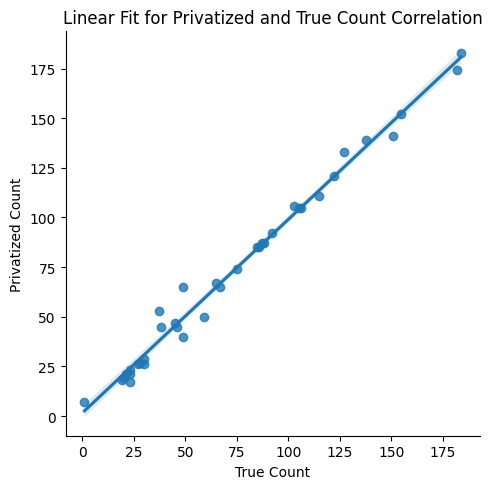

In [161]:
sns.lmplot(x='True Count', y='Privatized Count', data=pd.DataFrame({
    'True Count': filtered_df_plot['True Count'][1:],
    'Privatized Count': filtered_df_plot['Privatized Count'][1:]
}))
plt.title('Linear Fit for Privatized and True Count Correlation')
plt.tight_layout()
plt.show()